In [1]:
import math
import numpy as np
#import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
#from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

%matplotlib inline
np.random.seed(1)

In [2]:
X_train = np.loadtxt('X_train.csv', delimiter=',')
X_dev = np.loadtxt('X_dev.csv',delimiter=',')
X_test = np.loadtxt('X_test.csv',delimiter=',')
Y_train = np.loadtxt('Y_train.csv', delimiter=',')
Y_dev = np.loadtxt('Y_dev.csv', delimiter=',')
Y_test = np.loadtxt('Y_test.csv', delimiter=',')

In [3]:
Y_train = np.reshape(Y_train, (1, 5000))
Y_dev = np.reshape(Y_dev, (1, 1070))
Y_test = np.reshape(Y_test, (1, 1067))

In [4]:
print ("number of training examples = " + str(X_train.shape[1]))
print ("number of dev examples = " + str(X_dev.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_dev shape: " + str(X_dev.shape))
print ("Y_dev shape: " + str(Y_dev.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 5000
number of dev examples = 1070
number of test examples = 1067
X_train shape: (939, 5000)
Y_train shape: (1, 5000)
X_dev shape: (939, 1070)
Y_dev shape: (1, 1070)
X_test shape: (939, 1067)
Y_test shape: (1, 1067)


In [5]:
# Let's just try with activate/no activate
Y_train = 1.0*(Y_train!=0)
Y_dev = 1.0*(Y_dev!=0)
Y_test = 1.0*(Y_test!=0)

In [6]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of a small molecule vector (939)
    n_y -- scalar = 1
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
 
    """

    X = tf.placeholder(tf.float32, shape = [n_x, None], name = "X")
    Y = tf.placeholder(tf.float32, shape = [n_y, None], name = "Y")
    
    return X, Y

In [7]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, 939]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [1, 12]
                        b3 : [1, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1)               
        
    W1 = tf.get_variable("W1", [25,939], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12,25], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [12,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [1,12], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [1,1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [46]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1,X),b1)                                              
    A1 = tf.nn.relu(Z1)                                             
    Z2 = tf.add(tf.matmul(W2,A1),b2)                                            
    A2 = tf.nn.relu(Z2)                                             
    Z3 = tf.sigmoid(tf.add(tf.matmul(W3,A2),b3))                                        
    
    return Z3

In [144]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (1, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    scale = 60; 
    eps = 10e-3
    logits = tf.transpose(Z3) 
    labels = tf.transpose(Y)
    
    #cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels = labels, logits = logits))
    #cost = tf.add(tf.reduce_mean(tf.nn.l2_loss(Z3-Y)), tf.reduce_mean(tf.nn.l2_loss(tf.multiply(Y,Z3-Y))))
    cost = -tf.reduce_mean(tf.add(scale*tf.multiply(labels, tf.log(logits+eps)), tf.multiply(1-labels, tf.log(1-logits+eps))))
    #cost = tf.reduce_mean(tf.multiply(labels, tf.log(logits+eps)))
    
    return cost

In [145]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(939,1)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    print("cost = " + str(cost))

cost = Tensor("Neg:0", shape=(), dtype=float32)


In [146]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.01,
          num_epochs = 2300, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)
    

    # Initialize parameters
    parameters = initialize_parameters()
    
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):
            _ , epoch_cost = sess.run([optimizer, cost], feed_dict={X: X_train, Y: Y_train})

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
        
        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

X = Tensor("X_1:0", shape=(939, ?), dtype=float32)
Y = Tensor("Y_1:0", shape=(1, ?), dtype=float32)
Cost after epoch 0: 3.838337
Cost after epoch 100: 1.012507
Cost after epoch 200: 0.745185
Cost after epoch 300: 0.606641
Cost after epoch 400: 0.549458
Cost after epoch 500: 0.464942
Cost after epoch 600: 0.405751
Cost after epoch 700: 0.370832
Cost after epoch 800: 0.352667
Cost after epoch 900: 0.333823
Cost after epoch 1000: 0.321965
Cost after epoch 1100: 0.302055
Cost after epoch 1200: 0.285988
Cost after epoch 1300: 0.329244
Cost after epoch 1400: 0.314216
Cost after epoch 1500: 0.306788
Cost after epoch 1600: 0.293427
Cost after epoch 1700: 0.282986
Cost after epoch 1800: 0.325389
Cost after epoch 1900: 0.315707
Cost after epoch 2000: 0.309847
Cost after epoch 2100: 0.304705
Cost after epoch 2200: 0.300240


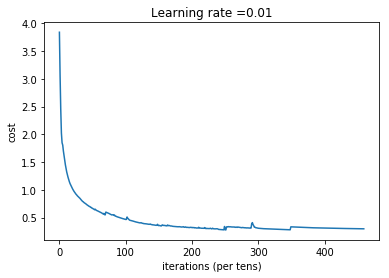

Parameters have been trained!
('Train Accuracy:', 1.0)
('Test Accuracy:', 1.0)


In [147]:
X, Y = create_placeholders(939, 1)
print ("X = " + str(X))
print ("Y = " + str(Y))
parameters = model(X_train, Y_train, X_test, Y_test)

In [148]:
with tf.Session() as sess:
    X, Y = create_placeholders(939,1)
    Z_train = sess.run(forward_propagation(X, parameters), feed_dict={X: X_train})
    Z_dev = sess.run(forward_propagation(X, parameters), feed_dict={X: X_dev})

In [166]:
P_train = Z_train >= 0.5
P_dev = Z_dev>=0.5

err_train = np.abs(P_train - Y_train)
err_dev = np.abs(P_dev - Y_dev)

# Error on the negative train examples
n_negative_train = (Y_train == 0).sum()
print("Train Accuracy on Negative Examples:",1-np.abs(err_train[Y_train == 0]).sum()/n_negative_train)

# Error on the negative dev examples
n_negative = (Y_dev == 0).sum()
print("Dev Accuracy on Negative Examples:", 1-np.abs(err_dev[Y_dev == 0]).sum()/n_negative)

# Error on the positive train examples
n_positive_train = (Y_train != 0).sum()
print("Train Accuracy on Positive Examples:", 1-np.abs(err_train[Y_train !=0]).sum()/n_positive_train)

# Error on the positive dev examples
n_positive = (Y_dev != 0).sum()
print("Dev Accuracy on Positive Examples:", 1-np.abs(err_dev[Y_dev !=0]).sum()/n_positive)



('Train Accuracy on Negative Examples:', 0.94839549002601908)
('Dev Accuracy on Negative Examples:', 0.9144869215291751)
('Train Accuracy on Positive Examples:', 0.99484536082474229)
('Dev Accuracy on Positive Examples:', 0.75)
